# Проверка гипотез и A/B теста

**В рамках проекта я сотрудничаю с отделом маркетинга интернет-магазина и мы подготовили список гипотез для увеличения выручки. Чтобы определить наиболее эффективные способы увеличения выручки, мы решили приоритизировать гипотезы и запустить A/B-тесты. Цель проекта - выявить наиболее эффективные изменения, которые помогут увеличить выручку интернет-магазина. После запуска тестов мы проанализируем полученные результаты и вынесем рекомендации для улучшения бизнес-показателей магазина.**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import math as mth
import scipy.stats as stats

In [2]:
plt.rcParams["figure.figsize"] = (15,5)

## Изучение данных

In [3]:
visitors = pd.read_csv('/datasets/visitors.csv')
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')

In [4]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [5]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [6]:
pd.options.display.max_colwidth=150
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


## Подготвка данных

In [9]:
#Приведем все таблицы к нормальному регистру
orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'}, inplace = True )
hypothesis.rename(columns = {'Hypothesis':'hypothesis', 'Reach':'reach', 'Impact':'impact', 'Confidence':'confidence'\
                             , 'Efforts':'efforts'}, inplace = True )

In [10]:
#Проверим пользователей
duplicated_user = []
for x in orders[orders['group']=='A']['visitor_id'].unique():
    if x in orders[orders['group']=='B']['visitor_id'].unique():        
        duplicated_user.append(x)
print('Повторы:', len(duplicated_user))

Повторы: 58


In [11]:
# И удалим их
orders = orders.loc[~orders['visitor_id'].isin(duplicated_user)].reset_index(drop=True)

In [12]:
#Приведем данные к нужному типу
orders = orders.astype({'date': "datetime64"})
visitors = visitors.astype({'date': "datetime64"})

**Промежуточные выводы**\
В данных были люди относящиеся к обеим группам. Так же привели все таблицы к необходимому виду и можем продолжать работать

In [13]:
#Проверим какой у нас тест парный или множественный
orders['group'].unique()

array(['B', 'A'], dtype=object)

In [14]:
#Посмотрим дату начала и дату окончания теста
print('Дата начала теста: ',orders['date'].min())
print('Дата окончания теста: ', orders['date'].max())

Дата начала теста:  2019-08-01 00:00:00
Дата окончания теста:  2019-08-31 00:00:00


In [15]:
#Проверим равенство групп
orders.groupby('group')['visitor_id'].nunique()

group
A    445
B    528
Name: visitor_id, dtype: int64

Видно, что группы не очень сбалансированы на 83 человек больше в группе В

In [16]:
#Проверим пропуски и дубликаты
print("Кол-во дубликатов orders =",orders.duplicated().sum())
print("Кол-во дубликатов visitors =",visitors.duplicated().sum())

print("Кол-во пропусков orders =",orders.isnull().sum().sum())
print("Кол-во пропусков visitor =",orders.isnull().sum().sum())

Кол-во дубликатов orders = 0
Кол-во дубликатов visitors = 0
Кол-во пропусков orders = 0
Кол-во пропусков visitor = 0


Нет ни пропусков, ни дубликатов

## Часть 1. Приоритизация гипотез.

In [17]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [18]:
pd.options.display.max_colwidth=65
hypothesis['ICE'] = round((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'],2)
display(hypothesis[['hypothesis','ICE']].sort_values('ICE',ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит п...",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собра...",11.20
6,Показать на главной странице баннеры с актуальными акциями и ...,8.00
2,Добавить блоки рекомендаций товаров на сайт интернет магазина...,7.00
1,"Запустить собственную службу доставки, что сократит срок дост...",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит у...",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. по...",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлечен...",1.00


In [19]:
hypothesis['RICE'] = round((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts'],2)
display(hypothesis[['hypothesis','RICE']].sort_values('RICE',ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собра...",112.0
2,Добавить блоки рекомендаций товаров на сайт интернет магазина...,56.0
0,"Добавить два новых канала привлечения трафика, что позволит п...",40.0
6,Показать на главной странице баннеры с актуальными акциями и ...,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. по...",9.0
1,"Запустить собственную службу доставки, что сократит срок дост...",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит у...",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлечен...",3.0


**Как можем заметить при сортировке по ICE первыми были 8,0,7 гипотеза, а при RICE 7,2,0. Такое случилось из-за того, что ICE не включает в себя оценку охвата пользователей. Так что небольшие изменения, но охватывающие всех пользователей в RICE будут лучше видны, чем в ICE.**

## Анализ A/B теста

### Проанализируем данные A/B теста

#### График кумулятивной выручки по группам

In [20]:
#Создам датафрейм datesGroups с уникальными парами значений 'date' и 'group'
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

In [21]:
#Объявим переменную ordersAggregated
ordersAggregated = datesGroups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
ordersAggregated.head()

,date,group,transaction_id,visitor_id,revenue
45,2019-08-01,A,23,19,142779
54,2019-08-01,B,17,17,59758
149,2019-08-02,A,42,36,234381
147,2019-08-02,B,40,39,221801
245,2019-08-03,A,66,60,346854


In [22]:
#Объявим переменную visitorsAggregated
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
                                                                         visitors['group'] == x['group'])].agg({'date' : 'max',\
                                                                                                                'group' : 'max',\
                                                                                                                'visitors' : 'sum'}),\
                                       axis=1).sort_values(by=['date','group'])
visitorsAggregated.head()

,date,group,visitors
45,2019-08-01,A,719
54,2019-08-01,B,713
149,2019-08-02,A,1338
147,2019-08-02,B,1294
245,2019-08-03,A,1845


In [23]:
#Объеденим две группы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


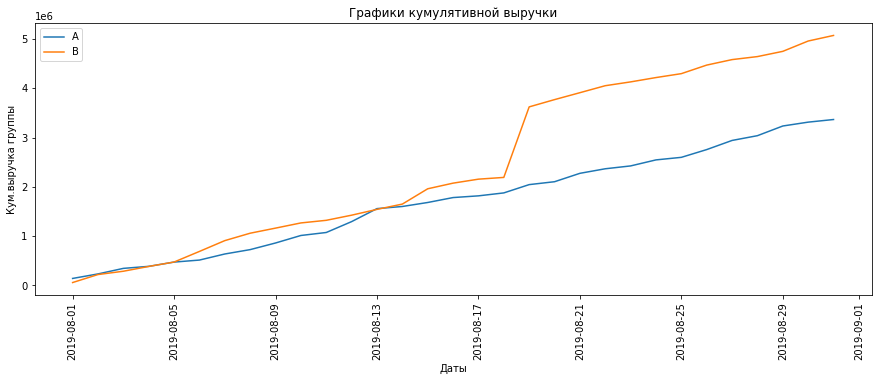

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Графики кумулятивной выручки')
plt.xlabel('Даты')
plt.ylabel('Кум.выручка группы')
plt.xticks(rotation=90)
plt.legend();

Видно, что в 17-08 произошел скачок группы B. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Такие выбросы проанализируем позже. 

#### График кумулятивного среднего чека по группам

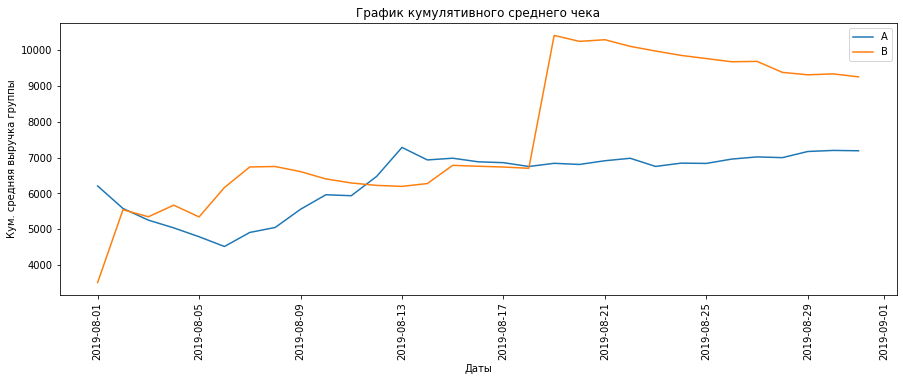

In [25]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека')
plt.xlabel('Даты')
plt.ylabel('Кум. средняя выручка группы')
plt.xticks(rotation=90)
plt.legend();

Из-за скачков пока нельзя сделать точные выводы.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

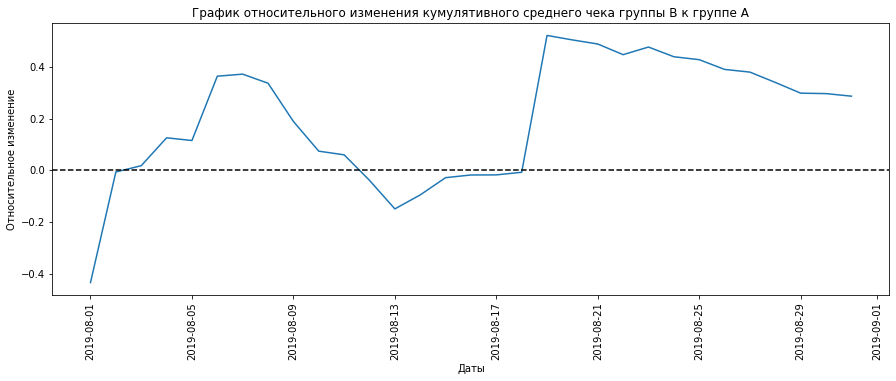

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение')
plt.xticks(rotation=90)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');


Можно отследить когда совершались аномально круппные заказы по скачкам.

#### График кумулятивного среднего количества заказов на посетителя по группам. 

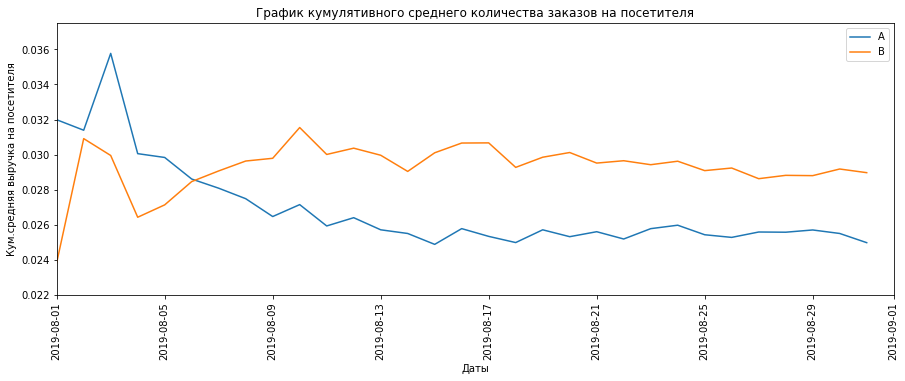

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.title('График кумулятивного среднего количества заказов на посетителя')
plt.xlabel('Даты')
plt.ylabel('Кум.средняя выручка на посетителя')
plt.xticks(rotation=90)
plt.legend()

# задаем масштаб осей

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.022, 0.0375]);

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

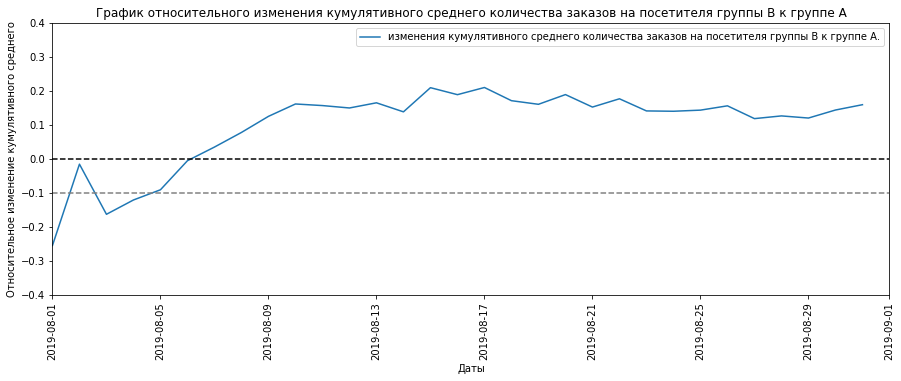

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.")
plt.legend()

plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Даты')
plt.ylabel('Относительное изменение кумулятивного среднего')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=90)
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.4,0.4]);

#### Постройте точечный график количества заказов по пользователям

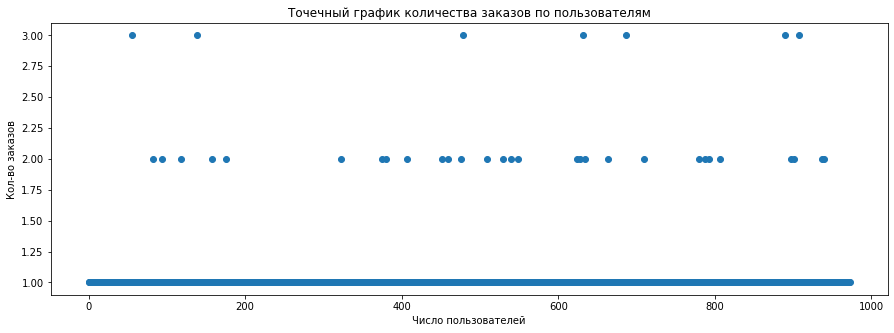

In [29]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Кол-во заказов')
plt.scatter(x_values, ordersByUsers['orders']);

Отлично видно, что больше 1 заказа совершает очень маленький процент людей. Чтобы в этом убедиться посчитаем 95-й и 99-й перцентили

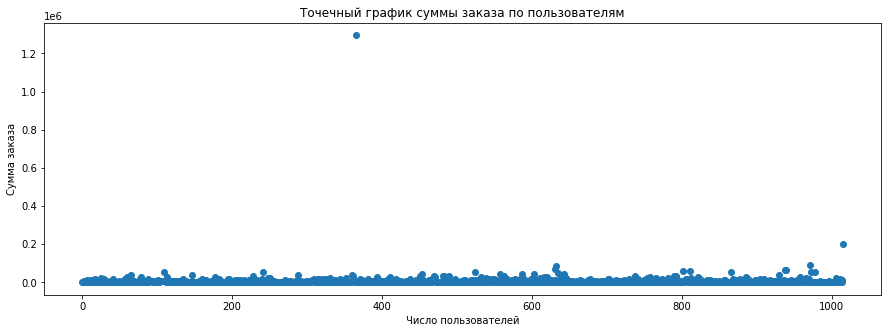

In [30]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.title('Точечный график суммы заказа по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Сумма заказа')
plt.scatter(x_values, orders['revenue']);

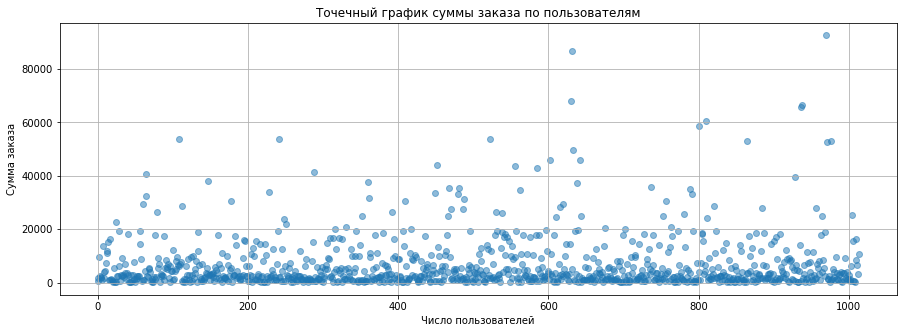

In [31]:
# Добавим график без двух больших заказов, чтобы лучше увидеть
xn_values = pd.Series(range(0,len(orders[orders['revenue']<=195000]['revenue'])))
plt.grid()
plt.title('Точечный график суммы заказа по пользователям')
plt.xlabel('Число пользователей')
plt.ylabel('Сумма заказа')
plt.scatter(xn_values, orders[orders['revenue']<=195000]['revenue'], alpha=0.5);

In [32]:
print(orders.sort_values(by='revenue', ascending=False).head(10))

      transaction_id  visitor_id       date  revenue group
365        590470918  1920142716 2019-08-19  1294500     B
1015      3936777065  2108080724 2019-08-15   202740     B
971        666610489  1307669133 2019-08-13    92550     A
632       3668308183   888512513 2019-08-27    86620     B
631       3603576309  4133034833 2019-08-09    67990     A
939       1348774318  1164614297 2019-08-12    66350     A
937        316924019   148427295 2019-08-12    65710     A
811       1347999392   887908475 2019-08-21    60450     A
802       2420050534  4003628586 2019-08-08    58550     B
109       3163614039  2254586615 2019-08-22    53904     A


#### 95-й и 99-й перцентили количества заказов и стоимости на пользователя.

In [33]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[1. 2.]


In [34]:
print(np.percentile(orders['revenue'], [90, 95, 99])) 

[17990. 26785. 53904.]


In [35]:
print('На основе этих данных можно задать следющие границы для пользователей:')
print('Не более {} Стоимость заказа не более {}'.format(np.percentile(ordersByUsers['orders'], 99), np.percentile(orders['revenue'], 99)))

На основе этих данных можно задать следющие границы для пользователей:
Не более 2.0 Стоимость заказа не более 53904.0


In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']


In [37]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 99)]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print("Аномальных пользователей: " ,len(abnormalUsers)) 

Аномальных пользователей:  16


In [38]:
len(abnormalUsers)/orders['visitor_id'].count() * 100

1.574803149606299

Всего аномальных пользователей 1.5% и мы можем удалить их без потери информативности

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

H0: Cтатистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным. \
H1: Cтатистически значимые различия в среднем количестве заказов на посетителя между группами по «сырым» данным есть.

In [39]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) 

alpha = 0.05
p-value = 0.011
Относительный показатель 'B' и 'A' = 0.160


Вывод: p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов на посетителя между группами по «сырым» данным - отвергаем. Получается по «сырым» данным различия в среднем количестве заказов групп A и B есть и составляет 16% в пользу группы B

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

H0: Статистически значимых различий в среднем чеке заказа между группами нет\
H1: Статистически значимые различия в среднем чеке заказа между группами есть.

In [40]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

alpha = 0.05
p-value = 0.829
Относительный показатель 'B' и 'A' = 0.287


Хоть разница по средней цене заказа в пользу группы B, разница оказалась не такой уж большой. Поэтому нулевую гипотезу отвергать нельзя

#### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [41]:
#Создадим две группы данных 
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(visitors[visitors['group']=='A']['visitors'].sum() - len(ordersByUsersA['orders'])), \
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'], \
                             pd.Series(0, index=np.arange(visitors[visitors['group']=='B']['visitors'].sum() - len(ordersByUsersB['orders'])), \
                                       name='orders')],axis=0) 

H0: Статистически значимых различий в среднем количестве заказов на посетителя между группами по «очищенным» данным\
H1: Статистически значимые различия в среднем количестве заказов на посетителя между группами по «очищенным» данным есть.

In [42]:
print("alpha =",0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1]))
print("Относительный показатель 'B' и 'A' = {0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 


alpha = 0.05
p-value = 0.007
Относительный показатель 'B' и 'A' = 0.189


Вывод: p-value = 0.007 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий  среднем количестве заказов на посетителя между группами по «очищенным» данным, - отвергаем. Это значит: и по «очищенным» данным различия в конверсии групп A и B есть. А относительный выигрыш группы "B" над "A" равен 19%

#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0: Статистически значимых различий в среднем чеке между группами между группами нет\
H1: Статистически значимые различия в среднем чеке между группами между группами есть.

In [43]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительный показатель 'B' и 'A' = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)


p-value = 0.788
Относительный показатель 'B' и 'A' = -0.032


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия нет. А вот средний чек оказался почти равным. В отличие от сырых данных, где один заказ на 1.2 млн очень сильно перевесил показатели

## Выводы

По результатам тестирования было выявлено:
И по "сырым" и по "очищенным" данным различия в среднем количестве заказов на посетителя между группами A и B есть. Относительный выигрыш группы "B" над "A" равен 19% по "очищенным" и 16% по "сырым" данным.

А вот по чекам разницы почти нет, так что люди стали оформлять больше заказов, но с таким же ценником.

**Результаты тестирования вполне однозначны. В итоге можно принять решение остановить тестирование и констатировать успех и победу группы B**